# TTC Subway Delay Analysis

In [1]:
#| include: false
!pip install geopandas

In [2]:
#| include: false
!pip install openmeteo-requests

  Using cached openmeteo_requests-1.4.0-py3-none-any.whl.metadata (9.7 kB)
  Using cached openmeteo_sdk-1.20.0-py3-none-any.whl.metadata (935 bytes)
Using cached openmeteo_requests-1.4.0-py3-none-any.whl (6.0 kB)
Using cached openmeteo_sdk-1.20.0-py3-none-any.whl (15 kB)


In [3]:
#| include: false
!pip install requests-cache retry-requests numpy pandas 

  Using cached requests_cache-1.2.1-py3-none-any.whl.metadata (9.9 kB)
  Using cached retry_requests-2.0.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached cattrs-24.1.3-py3-none-any.whl.metadata (8.4 kB)
  Using cached url_normalize-2.2.0-py3-none-any.whl.metadata (4.9 kB)
Using cached requests_cache-1.2.1-py3-none-any.whl (61 kB)
Using cached retry_requests-2.0.0-py3-none-any.whl (15 kB)
Using cached cattrs-24.1.3-py3-none-any.whl (66 kB)
Using cached url_normalize-2.2.0-py3-none-any.whl (14 kB)


#### Imports

In [4]:
#| include: false
import logging
logging.getLogger().setLevel(logging.ERROR)  # Suppress info/warning messages
import warnings
warnings.filterwarnings("ignore") 
import requests
from io import BytesIO
import pandas as pd
import geopandas as gpd
import time
import openmeteo_requests
import requests_cache
from retry_requests import retry
import os
import difflib
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Import TTC Subway Delay Data from 2024

In [5]:
#| include: false

delay_df = pd.read_excel("../data/ttc-subway-delay-data-2024.xlsx")

# Display first few rows of the dataset
print(delay_df.head())
print(delay_df.info())


        Date   Time     Day             Station   Code  Min Delay  Min Gap  \
0 2024-01-01  02:00  Monday    SHEPPARD STATION    MUI          0        0   
1 2024-01-01  02:00  Monday      DUNDAS STATION   MUIS          0        0   
2 2024-01-01  02:08  Monday      DUNDAS STATION  MUPAA          4       10   
3 2024-01-01  02:13  Monday  KENNEDY BD STATION  PUTDN         10       16   
4 2024-01-01  02:22  Monday       BLOOR STATION  MUPAA          4       10   

  Bound Line  Vehicle  
0     N   YU     5491  
1     N   YU        0  
2     N   YU     6051  
3     E   BD     5284  
4     N   YU     5986  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26467 entries, 0 to 26466
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       26467 non-null  datetime64[ns]
 1   Time       26467 non-null  object        
 2   Day        26467 non-null  object        
 3   Station    26467 non-null  object     

### Import Toronto Neighbourhood Profiles

In [6]:
#| include: false

# Load the Excel file
file_path = "../data/neighbourhood-profiles-2021-158-model.xlsx"

# Read the first sheet (modify `sheet_name` if necessary)
df = pd.read_excel(file_path, sheet_name=0)

# Set the first column as the index and transpose the DataFrame
df_t = df.set_index("Neighbourhood Name").transpose()

# # Print column names to verify structure
# print(df_t.columns.tolist())

# Extract only the Neighbourhood ID and Population columns
pop_df = df_t[["Neighbourhood Number", "Total - Age groups of the population - 25% sample data"]].copy()

# Rename columns for clarity
pop_df.rename(columns={"Neighbourhood Number": "neighbourhood_id",
                       "Total - Age groups of the population - 25% sample data": "population"}, inplace=True)

# Convert data types
pop_df["neighbourhood_id"] = pd.to_numeric(pop_df["neighbourhood_id"], errors="coerce")
pop_df["population"] = pd.to_numeric(pop_df["population"], errors="coerce")

# Display the cleaned DataFrame
print(pop_df.head())
print(pop_df.info())

Neighbourhood Name                 neighbourhood_id  population
West Humber-Clairville                            1       33300
Mount Olive-Silverstone-Jamestown                 2       31345
Thistletown-Beaumond Heights                      3        9850
Rexdale-Kipling                                   4       10375
Elms-Old Rexdale                                  5        9355
<class 'pandas.core.frame.DataFrame'>
Index: 158 entries, West Humber-Clairville to South Eglinton-Davisville
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   neighbourhood_id  158 non-null    int64
 1   population        158 non-null    int64
dtypes: int64(2)
memory usage: 3.7+ KB
None


### Import Toronto Neighbourhoods Shapefile

In [7]:
#| include: false

# Set the file path to your shapefile (ensure it's in the same directory or provide the full path)
shapefile_path = "../data/Neighbourhoods - 4326/Neighbourhoods - 4326.shp"  # Adjust filename if necessary

# Load the shapefile using GeoPandas
toronto_gdf = gpd.read_file(shapefile_path)

# Display basic information about the shapefile
print(toronto_gdf.info())

# Display the first few rows
print(toronto_gdf.head())


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   _id1       158 non-null    int64   
 1   AREA_ID2   158 non-null    int64   
 2   AREA_AT3   158 non-null    int64   
 3   PARENT_4   158 non-null    int64   
 4   AREA_SH5   158 non-null    object  
 5   AREA_LO6   158 non-null    object  
 6   AREA_NA7   158 non-null    object  
 7   AREA_DE8   158 non-null    object  
 8   CLASSIF9   158 non-null    object  
 9   CLASSIF10  158 non-null    object  
 10  OBJECTI11  158 non-null    float64 
 11  geometry   158 non-null    geometry
dtypes: float64(1), geometry(1), int64(4), object(6)
memory usage: 14.9+ KB
None
   _id1  AREA_ID2  AREA_AT3  PARENT_4 AREA_SH5 AREA_LO6  \
0     1   2502366  26022881         0      174      174   
1     2   2502365  26022880         0      173      173   
2     3   2502364  26022879         0      172      172

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


### Create dictionary of subway station names

In [8]:
#| include: false

# Define TTC subway stations by line
stations_by_line = {
    'YU': [
        "FINCH STATION", "NORTH YORK CENTRE STATION", "SHEPPARD-YONGE STATION", "YORK MILLS STATION",
        "LAWRENCE STATION", "EGLINTON STATION", "DAVISVILLE STATION", "ST CLAIR STATION",
        "SUMMERHILL STATION", "ROSEDALE STATION", "BLOOR-YONGE STATION", "WELLESLEY STATION",
        "COLLEGE STATION", "DUNDAS STATION", "QUEEN STATION", "KING STATION", "UNION STATION",
        "ST ANDREW STATION", "OSGOODE STATION", "ST PATRICK STATION", "QUEEN'S PARK STATION",
        "MUSEUM STATION", "ST GEORGE STATION", "SPADINA STATION", "DUPONT STATION",
        "ST CLAIR WEST STATION", "EGLINTON WEST STATION", "GLENCAIRN STATION", "LAWRENCE WEST STATION",
        "YORKDALE STATION", "WILSON STATION", "SHEPPARD WEST STATION", "DOWNSVIEW PARK STATION",
        "FINCH WEST STATION", "YORK UNIVERSITY STATION", "PIONEER VILLAGE STATION",
        "HIGHWAY 407 STATION", "VAUGHAN METROPOLITAN CENTRE STATION"
    ],
    'BD': [
        "KIPLING STATION", "ISLINGTON STATION", "ROYAL YORK STATION", "OLD MILL STATION",
        "JANE STATION", "RUNNYMEDE STATION", "HIGH PARK STATION", "KEELE STATION",
        "DUNDAS WEST STATION", "LANSDOWNE STATION", "DUFFERIN STATION", "OSSINGTON STATION",
        "CHRISTIE STATION", "BATHURST STATION", "SPADINA STATION", "ST GEORGE STATION",
        "BAY STATION", "BLOOR-YONGE STATION", "SHERBOURNE STATION", "CASTLE FRANK STATION",
        "BROADVIEW STATION", "CHESTER STATION", "PAPE STATION", "DONLANDS STATION",
        "GREENWOOD STATION", "COXWELL STATION", "WOODBINE STATION", "MAIN STREET STATION",
        "VICTORIA PARK STATION", "WARDEN STATION", "KENNEDY STATION"
    ],
    'SHP': [
        "SHEPPARD-YONGE STATION", "BAYVIEW STATION", "BESSARION STATION",
        "LESLIE STATION", "DON MILLS STATION"
    ]
}


### Retrieve coordinates of subway stations

In [9]:
#| include: false

def get_station_coordinates(station_name):
    """
    Retrieves the latitude and longitude of a TTC subway station using OpenStreetMap's Nominatim API.
    Handles errors and retries in case of failure.
    """
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": f"{station_name}, Ontario, Canada",
        "format": "json",
        "limit": 1
    }

    try:
        response = requests.get(base_url, params=params, headers={"User-Agent": "Mozilla/5.0"})
        
        # Check if response is empty or the request failed
        if response.status_code != 200:
            print(f"Error: Received status code {response.status_code} for {station_name}")
            return None, None

        data = response.json()
        
        if data:
            return float(data[0]["lat"]), float(data[0]["lon"])
        else:
            print(f"Warning: No coordinates found for {station_name}")
            return None, None

    except requests.exceptions.RequestException as e:
        print(f"Request error: {e}")
        return None, None
    except ValueError:
        print(f"JSON decoding error for {station_name}")
        return None, None

In [10]:
#| include: false

# Get all unique station names from stations_by_line
unique_stations = set(station for stations in stations_by_line.values() for station in stations)

# Create an empty list to store station data
station_data = []

# Retrieve coordinates for each unique station
for station in unique_stations:
    lat, lon = get_station_coordinates(station)
    station_data.append({"station": station, "latitude": lat, "longitude": lon})
    print(f"Retrieved: {station} -> ({lat}, {lon})")
    time.sleep(1.5)  # Delay to prevent exceeding API rate limits

# Convert list to a DataFrame
stations_df = pd.DataFrame(station_data)

# Display first few rows
print(stations_df.head())
print(stations_df.info())

Retrieved: FINCH STATION -> (43.7827501, -79.41488829825582)
Retrieved: ST ANDREW STATION -> (43.6477917, -79.3848711)
Retrieved: KIPLING STATION -> (43.63753245, -79.53560410315569)
Retrieved: GREENWOOD STATION -> (43.6824765, -79.3302798)
Retrieved: ISLINGTON STATION -> (43.645335, -79.5248163)
Retrieved: BROADVIEW STATION -> (43.6770471, -79.35839530606879)
Retrieved: PIONEER VILLAGE STATION -> (43.7768779, -79.5089377)
Retrieved: BATHURST STATION -> (43.66641590196867, -79.41130918066413)
Retrieved: BESSARION STATION -> (43.7690604, -79.37588370821047)
Retrieved: COLLEGE STATION -> (43.6606617, -79.3827952)
Retrieved: LAWRENCE WEST STATION -> (43.7148335, -79.44374061169376)
Retrieved: SHERBOURNE STATION -> (43.67218771983478, -79.37648191432166)
Retrieved: EGLINTON STATION -> (43.7049424, -79.3985309)
Retrieved: NORTH YORK CENTRE STATION -> (43.7686787, -79.4126298)
Retrieved: ST CLAIR WEST STATION -> (43.6842388, -79.4153753)
Retrieved: KING STATION -> (43.6485227, -79.3777728)
R

### Retrieve Hourly Weather Data from 2024

In [11]:
#| include: false

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 43.7001,
    "longitude": -79.4163,
    "start_date": "2024-01-01",
    "end_date": "2024-12-31",
    "hourly": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation", "rain", "snowfall", "snow_depth", "cloud_cover", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m", "is_day"],
    "timezone": "America/New_York",
    "temporal_resolution": "native"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(2).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
hourly_rain = hourly.Variables(4).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(5).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(6).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(7).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(8).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(10).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
)}

hourly_data["temperature"] = hourly_temperature_2m
hourly_data["relative_humidity"] = hourly_relative_humidity_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["snow_depth"] = hourly_snow_depth
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["wind_speed"] = hourly_wind_speed_10m
hourly_data["wind_gusts"] = hourly_wind_gusts_10m

weather_df = pd.DataFrame(data = hourly_data)
print(weather_df)

print(weather_df.head())
print(weather_df.info())


Coordinates 43.6906852722168°N -79.4117431640625°E
Elevation 175.0 m asl
Timezone b'America/New_York'b'GMT-4'
Timezone difference to GMT+0 -14400 s
                          date  temperature  relative_humidity  \
0    2024-01-01 04:00:00+00:00        0.036          87.680656   
1    2024-01-01 05:00:00+00:00       -0.314          86.681801   
2    2024-01-01 06:00:00+00:00       -0.814          84.406464   
3    2024-01-01 07:00:00+00:00       -1.114          82.810249   
4    2024-01-01 08:00:00+00:00       -1.614          81.205139   
...                        ...          ...                ...   
8779 2024-12-31 23:00:00+00:00        3.086          86.090363   
8780 2025-01-01 00:00:00+00:00        3.236          88.295639   
8781 2025-01-01 01:00:00+00:00        3.336          91.842354   
8782 2025-01-01 02:00:00+00:00        3.286          94.491371   
8783 2025-01-01 03:00:00+00:00        3.436          93.164978   

      apparent_temperature  precipitation  rain  snowfall  

#### Save weather data in data folder

In [12]:
#| include: false

# save dfs retrieved using apis

# Define the path to the data folder
data_folder = "../data"

# Create the folder if it doesn't exist
os.makedirs(data_folder, exist_ok=True)

# Save weather_df as CSV
weather_df.to_csv(os.path.join(data_folder, "weather_data.csv"), index=False)

print("File saved successfully in the data folder!")

File saved successfully in the data folder!


### Data Cleaning

#### Check delay_df

In [13]:
#| include: false
print(delay_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26467 entries, 0 to 26466
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       26467 non-null  datetime64[ns]
 1   Time       26467 non-null  object        
 2   Day        26467 non-null  object        
 3   Station    26467 non-null  object        
 4   Code       26467 non-null  object        
 5   Min Delay  26467 non-null  int64         
 6   Min Gap    26467 non-null  int64         
 7   Bound      16947 non-null  object        
 8   Line       26423 non-null  object        
 9   Vehicle    26467 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 2.0+ MB
None


In [14]:
#| include: false

# Remove a 'Min Gap' and 'Vehicle' column
delay_df = delay_df.drop(columns=["Min Gap"])
delay_df = delay_df.drop(columns=["Vehicle"])

In [15]:
#| include: false

# Rename columns for clarity
delay_df.rename(columns={"Date": "date", "Time": "time", "Day": "day", "Station": "station", "Code": "code", 
                         "Min Delay": "min_delay", "Bound": "bound", "Line": "line"}, inplace=True)

In [16]:
#| include: false
# Checking for missing values and duplicates in delay_df
print("\nMissing Values in Delay DataFrame:\n", delay_df.isnull().sum())
print("\nDuplicate Rows in Delay DataFrame:", delay_df.duplicated().sum())


Missing Values in Delay DataFrame:
 date            0
time            0
day             0
station         0
code            0
min_delay       0
bound        9520
line           44
dtype: int64

Duplicate Rows in Delay DataFrame: 20


In [17]:
#| include: false
# Handling missing values in delay data
delay_df = delay_df.dropna(subset=['bound'])  # Drop rows where min_delay is missing
delay_df = delay_df.dropna(subset=['line'])

# Drop duplicate rows in delay_df
delay_df = delay_df.drop_duplicates()

# Checking for missing values and duplicates in delay_df
print("\nMissing Values in Delay DataFrame:\n", delay_df.isnull().sum())
print("\nDuplicate Rows in Delay DataFrame:", delay_df.duplicated().sum())

print("Delay DataFrame Shape:", delay_df.shape)


Missing Values in Delay DataFrame:
 date         0
time         0
day          0
station      0
code         0
min_delay    0
bound        0
line         0
dtype: int64

Duplicate Rows in Delay DataFrame: 0
Delay DataFrame Shape: (16935, 8)


In [18]:
#| include: false
print("Unique values in 'day' column:", delay_df['day'].unique())

day_counts = delay_df['day'].value_counts()

print(day_counts)

Unique values in 'day' column: ['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']
day
Tuesday      2724
Thursday     2636
Friday       2570
Wednesday    2568
Monday       2508
Saturday     2187
Sunday       1742
Name: count, dtype: int64


In [19]:
#| include: false


# Define the correct order for days
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Convert 'day' column to a categorical type with the specified order
delay_df['day'] = pd.Categorical(delay_df['day'], categories=day_order, ordered=True)

In [20]:
#| include: false
print("Unique values in 'code' column:", delay_df['code'].unique())

code_counts = delay_df['code'].value_counts()

print(code_counts)

Unique values in 'code' column: ['MUI' 'MUIS' 'MUPAA' 'PUTDN' 'MUIRS' 'EUDO' 'MUIR' 'SUDP' 'TUNOA' 'TUNIP'
 'SUO' 'PUOPO' 'SUSA' 'TUSC' 'MUDD' 'SUUT' 'MUNOA' 'MUO' 'MUSAN' 'EUME'
 'MUSC' 'TUO' 'SUEAS' 'TUS' 'EUVE' 'EUCA' 'EUSC' 'TUOS' 'MUPR1' 'PUSAC'
 'EUPI' 'SUAP' 'MUTO' 'EUOPO' 'PUSSW' 'PUSRA' 'MUATC' 'TUMVS' 'SUG' 'EUBK'
 'SUAE' 'PUSI' 'PUSCR' 'MUD' 'EUAC' 'TUSET' 'SUROB' 'MUFS' 'TUATC' 'EUNT'
 'PUMEL' 'PUTOE' 'PUTO' 'SUPOL' 'PUSIS' 'EUCD' 'PUTWZ' 'MUPLC' 'PUSTS'
 'EUYRD' 'PUTR' 'MUPLB' 'MUWR' 'PUMO' 'MUNCA' 'MUCL' 'EUAL' 'EUVA' 'PUSTC'
 'EUATC' 'PUTIS' 'TUCC' 'TUSUP' 'PUSNT' 'PUSO' 'EUTRD' 'PUTS' 'TUOPO'
 'EUCO' 'EUBO' 'MUIE' 'EUOE' 'PUCSS' 'MUGD' 'EUO' 'PUATC' 'PUTSC' 'TUST'
 'MUWEA' 'MUTD' 'EUTR' 'PUTIJ' 'SUSP' 'MUPF' 'PUTSM' 'EUNEA' 'PUSTP'
 'SUBT' 'TUKEY' 'PUMST' 'PUEO' 'TUML' 'PUCSC' 'EUECD' 'EULV' 'PUSWZ'
 'PUEME' 'EULT' 'PUTD' 'EUTM' 'XXXXX' 'EUTL' 'PUSCA' 'PUEWZ' 'MUPLA'
 'TUDOE' 'PUTTC' 'PUSIO' 'TUNCA' 'MUEC' 'EUHV' 'MUESA' 'PUSZC' 'PUTTP']
code
SUDP     2250
MUPAA    1715

In [21]:
#| include: false

# Convert 'code' column to category type
delay_df['code'] = delay_df['code'].astype('category')

In [22]:
#| include: false
print("Unique values in 'bound' column:", delay_df['bound'].unique())

bound_counts = delay_df['bound'].value_counts()

print(bound_counts)

Unique values in 'bound' column: ['N' 'E' 'S' 'W' 'B']
bound
S    4741
N    4509
W    3850
E    3811
B      24
Name: count, dtype: int64


In [23]:
#| include: false
# Drop rows where 'bound' column is exactly 'B'
delay_df = delay_df.loc[delay_df['bound'] != 'B']

# Display the updated shape of the DataFrame
print("Updated Delay DataFrame Shape:", delay_df.shape)

Updated Delay DataFrame Shape: (16911, 8)


In [24]:
#| include: false

# Convert 'bound' column to category type
delay_df['bound'] = delay_df['bound'].astype('category')

In [25]:
#| include: false
print("Unique values in 'line' column:", delay_df['line'].unique())

line_counts = delay_df['line'].value_counts()

print(line_counts)

Unique values in 'line' column: ['YU' 'BD' 'YUS' 'SHP']
line
YU     9268
BD     7067
SHP     572
YUS       4
Name: count, dtype: int64


In [26]:
#| include: false
print(delay_df.loc[delay_df['line'] == "YUS"])

            date   time        day        station   code  min_delay bound line
26    2024-01-01  09:45     Monday  QUEEN STATION    SUO         10     S  YUS
7867  2024-04-17  22:46  Wednesday   KING STATION    SUO          5     N  YUS
12840 2024-06-26  13:38  Wednesday  BLOOR STATION  MUIRS          0     N  YUS
24507 2024-12-05  17:08   Thursday  FINCH STATION   MUIR          3     S  YUS


In [27]:
#| include: false
delay_df.loc[delay_df['line'] == 'YUS', 'line'] = 'YU'
print("Delay DataFrame Shape:", delay_df.shape)

Delay DataFrame Shape: (16911, 8)


In [28]:
#| include: false
print("Unique values in 'line' column:", delay_df['line'].unique())

line_counts = delay_df['line'].value_counts()

print(line_counts)

Unique values in 'line' column: ['YU' 'BD' 'SHP']
line
YU     9272
BD     7067
SHP     572
Name: count, dtype: int64


In [29]:
#| include: false

# Convert 'line' column to category type
delay_df['line'] = delay_df['line'].astype('category')

In [30]:
#| include: false
print("Unique values in 'station' column:", delay_df['station'].unique())

station_counts = delay_df['station'].value_counts()

print(station_counts)

Unique values in 'station' column: ['SHEPPARD STATION' 'DUNDAS STATION' 'KENNEDY BD STATION' 'BLOOR STATION'
 'ST CLAIR STATION' 'WOODBINE STATION' 'FINCH STATION'
 'DAVISVILLE STATION' 'COLLEGE STATION' 'LAWRENCE WEST STATION'
 'SHEPPARD WEST STATION' 'EGLINTON STATION' 'SUMMERHILL STATION'
 'QUEEN STATION' 'OLD MILL STATION' 'SPADINA YUS STATION'
 'ST PATRICK STATION' 'YONGE BD STATION' 'LANSDOWNE STATION'
 'ROSEDALE STATION' 'DUFFERIN STATION' 'DONLANDS STATION'
 'ST GEORGE YUS STATION' 'VAUGHAN MC STATION' 'SPADINA BD STATION'
 'BROADVIEW STATION' 'FINCH WEST STATION' "QUEEN'S PARK STATION"
 'DOWNSVIEW PARK STATION' 'KEELE STATION' 'NORTH YORK CTR STATION'
 'KIPLING STATION' 'MUSEUM STATION' 'ISLINGTON STATION'
 'PIONEER VILLAGE STATIO' 'WARDEN STATION' 'WELLESLEY STATION'
 'SHERBOURNE STATION' 'YORKDALE STATION' 'EGLINTON WEST STATION'
 'JANE STATION' 'SHEPPARD-YONGE STATION' 'DON MILLS STATION'
 'BAYVIEW STATION' 'UNION STATION' 'VICTORIA PARK STATION'
 'MAIN STREET STATION' 'LAW

In [31]:
#| include: false

def clean_station_name(station, line):
    """ Cleans and standardizes station names while keeping 'STATION' and handling edge cases. """

    # Handle 'X TO Y' cases by keeping 'Y'
    if " TO " in station:
        station = station.split(" TO ")[-1]
    elif " - " in station:
        station = station.split(" - ")[-1]

    # Remove extra text like "(APPROA", "(TOWARD", "(LEAVIN"
    station = station.split("(")[0].strip()

    # Ensure "STATION" is present in the cleaned name
    if "STATION" not in station:
        station += " STATION"

    # Fix known typos
    typo_fixes = {
        "BLOOR SATION STATION": "BLOOR STATION",
        "PAPE STATIO STATION": "PAPE STATION",
        "YONGE BD  (ON R STATION": "BLOOR-YONGE STATION",
        "MUSUEM STATION": "MUSEUM STATION",
        "NORTH YORK CTR STATION": "NORTH YORK CENTRE STATION"
    }
    if station in typo_fixes:
        return typo_fixes[station]
    
    # Fix known edge cases where the line name is in the station name
    line_fixes = {
        "YONGE BD STATION": "BLOOR-YONGE STATION",
        "VAUGHAN MC STATION": "VAUGHAN METROPOLITAN CENTRE STATION",
        "SPADINA BD STATION": "SPADINA STATION",
        "SPADINA YUS STATION": "SPADINA STATION",
        "ST GEORGE YUS STATION": "ST GEORGE STATION",
        "ST GEORGE BD STATION": "ST GEORGE STATION",
        "KENNEDY BD STATION": "KENNEDY STATION"
    }
    if station in line_fixes:
        return line_fixes[station]

    # Handle intersections (e.g., "BLOOR-YONGE STATION" and "SHEPPARD-YONGE STATION")
    if "YONGE" in station and "BLOOR" in station:
        return "BLOOR-YONGE STATION"
    if "YONGE" in station and "SHEPPARD" in station:
        return "SHEPPARD-YONGE STATION"

    # Get the correct station list based on the line
    valid_stations = stations_by_line.get(line, [])

    # Find closest match using difflib
    closest_matches = difflib.get_close_matches(station, valid_stations, n=1, cutoff=0.8)

    # Return the best match if found, else return the station with "STATION" added
    return closest_matches[0] if closest_matches else station


In [32]:
#| include: false
# Apply cleaning function to the 'station' column
delay_df['cleaned_station'] = delay_df.apply(lambda row: clean_station_name(row['station'], row['line']), axis=1)

# Display before/after cleaning
print(delay_df[['station', 'cleaned_station']].head(20))


                  station        cleaned_station
0        SHEPPARD STATION  SHEPPARD WEST STATION
1          DUNDAS STATION         DUNDAS STATION
2          DUNDAS STATION         DUNDAS STATION
3      KENNEDY BD STATION        KENNEDY STATION
4           BLOOR STATION    BLOOR-YONGE STATION
5        ST CLAIR STATION       ST CLAIR STATION
6           BLOOR STATION    BLOOR-YONGE STATION
7        WOODBINE STATION       WOODBINE STATION
8           FINCH STATION          FINCH STATION
9      DAVISVILLE STATION     DAVISVILLE STATION
10          FINCH STATION          FINCH STATION
11        COLLEGE STATION        COLLEGE STATION
12  LAWRENCE WEST STATION  LAWRENCE WEST STATION
13  LAWRENCE WEST STATION  LAWRENCE WEST STATION
20  SHEPPARD WEST STATION  SHEPPARD WEST STATION
21       EGLINTON STATION       EGLINTON STATION
22  SHEPPARD WEST STATION  SHEPPARD WEST STATION
23        COLLEGE STATION        COLLEGE STATION
24       ST CLAIR STATION       ST CLAIR STATION
25     SUMMERHILL ST

In [33]:
#| include: false
# Create a set of all valid station names from stations_by_line
valid_stations = set(station for stations in stations_by_line.values() for station in stations)

# Find non-matching stations
non_matching_stations = delay_df[~delay_df['cleaned_station'].isin(valid_stations)]

# Display the count of affected rows
print(f"Number of rows with non-matching station names: {non_matching_stations.shape[0]}")
print("Sample of non-matching stations:")
print(non_matching_stations[['station', 'cleaned_station']].head(10))  # Display a few examples


Number of rows with non-matching station names: 34
Sample of non-matching stations:
                     station                 cleaned_station
1796  FINCH WEST CENTER TRAC  FINCH WEST CENTER TRAC STATION
2721  UNION STATION--ST ANDR          UNION STATION--ST ANDR
3283     BLOOR DANFORTH LINE     BLOOR DANFORTH LINE STATION
3433      UNION CENTRE TRACK      UNION CENTRE TRACK STATION
3814  WILSON YARD HOSTLER #2  WILSON YARD HOSTLER #2 STATION
4203           GUNN BUILDING           GUNN BUILDING STATION
5922            BLOOR SATION                   BLOOR STATION
6225  YONGE UNIVERSITY SUBWA  YONGE UNIVERSITY SUBWA STATION
6417   UNION STATION TOWARDS           UNION STATION TOWARDS
9825  BROADVIEW AND ST GEORG  BROADVIEW AND ST GEORG STATION


In [34]:
#| include: false
# Remove rows where 'cleaned_station' is not in the valid TTC station list
delay_df = delay_df[delay_df['cleaned_station'].isin(valid_stations)]

# Display the updated shape of the DataFrame
print("Updated Delay DataFrame Shape:", delay_df.shape)


Updated Delay DataFrame Shape: (16877, 9)


In [35]:
#| include: false
print("Unique values in 'cleaned_station' column:", delay_df['cleaned_station'].unique())

cleaned_station_counts = delay_df['cleaned_station'].value_counts()

print(cleaned_station_counts)

Unique values in 'cleaned_station' column: ['SHEPPARD WEST STATION' 'DUNDAS STATION' 'KENNEDY STATION'
 'BLOOR-YONGE STATION' 'ST CLAIR STATION' 'WOODBINE STATION'
 'FINCH STATION' 'DAVISVILLE STATION' 'COLLEGE STATION'
 'LAWRENCE WEST STATION' 'EGLINTON STATION' 'SUMMERHILL STATION'
 'QUEEN STATION' 'OLD MILL STATION' 'SPADINA STATION' 'ST PATRICK STATION'
 'LANSDOWNE STATION' 'ROSEDALE STATION' 'DUFFERIN STATION'
 'DONLANDS STATION' 'ST GEORGE STATION'
 'VAUGHAN METROPOLITAN CENTRE STATION' 'BROADVIEW STATION'
 'FINCH WEST STATION' "QUEEN'S PARK STATION" 'DOWNSVIEW PARK STATION'
 'KEELE STATION' 'NORTH YORK CENTRE STATION' 'KIPLING STATION'
 'MUSEUM STATION' 'ISLINGTON STATION' 'PIONEER VILLAGE STATION'
 'WARDEN STATION' 'WELLESLEY STATION' 'SHERBOURNE STATION'
 'YORKDALE STATION' 'EGLINTON WEST STATION' 'JANE STATION'
 'SHEPPARD-YONGE STATION' 'DON MILLS STATION' 'BAYVIEW STATION'
 'UNION STATION' 'VICTORIA PARK STATION' 'MAIN STREET STATION'
 'LAWRENCE STATION' 'BAY STATION' 'WILSO

In [36]:
#| include: false

# Change 'cleaned_station' column to category type
delay_df['cleaned_station'] = delay_df['cleaned_station'].astype('category')

In [37]:
#| include: false

# Remove a 'station' column
delay_df = delay_df.drop(columns=["station"])

print(delay_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 16877 entries, 0 to 26466
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             16877 non-null  datetime64[ns]
 1   time             16877 non-null  object        
 2   day              16877 non-null  category      
 3   code             16877 non-null  category      
 4   min_delay        16877 non-null  int64         
 5   bound            16877 non-null  category      
 6   line             16877 non-null  category      
 7   cleaned_station  16877 non-null  category      
dtypes: category(5), datetime64[ns](1), int64(1), object(1)
memory usage: 618.1+ KB
None


In [38]:
#| include: false
# Summary statistics for Delay Data (formatted)
delay_summary = delay_df.describe().T  # Transpose for better readability
delay_summary.style.set_caption("Delay Data Summary").format("{:.2f}")


,count,mean,min,25%,50%,75%,max,std
date,16877.00,.2f,.2f,.2f,.2f,.2f,.2f,nan
min_delay,16877.00,4.28,0.00,0.00,3.00,5.00,640.00,11.04


In [39]:
#| include: false
# The maximum value in min_delay is 716 minutes, just under 12 hours. 
# I will check how many delays lasted longer than one hour.

In [40]:
#| include: false
# Get all rows where min_delay is greater than 10
high_delay_df = delay_df.loc[delay_df['min_delay'] > 30]

print(high_delay_df.shape)

# Display the first few rows
print(high_delay_df.head())


(199, 8)
          date   time        day   code  min_delay bound line  \
164 2024-01-03  20:10  Wednesday   EUPI         43     S   YU   
216 2024-01-04  11:10   Thursday  PUSSW         92     E   BD   
418 2024-01-07  10:17     Sunday   SUUT         50     E  SHP   
591 2024-01-09  00:50    Tuesday   SUUT         35     S   YU   
873 2024-01-14  11:22     Sunday  MUPLB         66     S   YU   

                         cleaned_station  
164  VAUGHAN METROPOLITAN CENTRE STATION  
216                       WARDEN STATION  
418                      BAYVIEW STATION  
591                   FINCH WEST STATION  
873                   DAVISVILLE STATION  


In [41]:
#| include: false
# Get all rows where min_delay is equalt to 0
no_delay_df = delay_df.loc[delay_df['min_delay'] == 0]

print(no_delay_df.shape)

# Display the first few rows
print(no_delay_df.head())

(7640, 8)
         date   time     day   code  min_delay bound line  \
0  2024-01-01  02:00  Monday    MUI          0     N   YU   
1  2024-01-01  02:00  Monday   MUIS          0     N   YU   
6  2024-01-01  02:25  Monday  MUIRS          0     S   YU   
8  2024-01-01  02:28  Monday  MUIRS          0     S   YU   
13 2024-01-01  03:06  Monday   MUIS          0     S   YU   

          cleaned_station  
0   SHEPPARD WEST STATION  
1          DUNDAS STATION  
6     BLOOR-YONGE STATION  
8           FINCH STATION  
13  LAWRENCE WEST STATION  


In [42]:
#| include: false
# I will focus on delays that lasted for at most one hour, as only 147 delays lasted longer than this. 
# Additionally, these significantly longer delays were most likely due to major incidents, 
# which are outside the scope of this study.

In [43]:
#| include: false
delay_df = delay_df.loc[delay_df['min_delay'] <= 30]
print("Delay DataFrame Shape:", delay_df.shape)

Delay DataFrame Shape: (16678, 8)


In [44]:
#| include: false
delay_df = delay_df.loc[delay_df['min_delay'] > 0]
print("Delay DataFrame Shape:", delay_df.shape)

Delay DataFrame Shape: (9038, 8)


In [45]:
#| inlcude: false
# Summary statistics for Delay Data (formatted)
delay_summary = delay_df.describe().T  # Transpose for better readability
delay_summary.style.set_caption("Delay Data Summary").format("{:.2f}")

,count,mean,min,25%,50%,75%,max,std
date,9038.00,.2f,.2f,.2f,.2f,.2f,.2f,nan
min_delay,9038.00,6.56,2.00,4.00,5.00,7.00,30.00,4.79


In [46]:
#| include: false

# Extract only the hour from the 'time' column and convert it to an integer (0-23)
delay_df['hour'] = delay_df['time'].str[:2].astype(int)

# Display result
print(delay_df[['time', 'hour']].head())


    time  hour
2  02:08     2
3  02:13     2
4  02:22     2
5  02:25     2
7  02:27     2


In [47]:
#| include: false

# Display column types to verify
print(delay_df.dtypes)

date               datetime64[ns]
time                       object
day                      category
code                     category
min_delay                   int64
bound                    category
line                     category
cleaned_station          category
hour                        int64
dtype: object


#### Check pop_df

In [48]:
#| include: false
print(pop_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 158 entries, West Humber-Clairville to South Eglinton-Davisville
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   neighbourhood_id  158 non-null    int64
 1   population        158 non-null    int64
dtypes: int64(2)
memory usage: 3.7+ KB
None


#### Check toronto_gdf

In [49]:
#| include: false
# List all column names in the shapefile
print("Columns in the shapefile:", toronto_gdf.columns.tolist())

Columns in the shapefile: ['_id1', 'AREA_ID2', 'AREA_AT3', 'PARENT_4', 'AREA_SH5', 'AREA_LO6', 'AREA_NA7', 'AREA_DE8', 'CLASSIF9', 'CLASSIF10', 'OBJECTI11', 'geometry']


In [50]:
#| include: false
# Rename a column in toronto_gdf
toronto_gdf.rename(columns={"_id1": "neighbourhood_id"}, inplace=True)

# Display the updated columns
print(toronto_gdf.columns)

Index(['neighbourhood_id', 'AREA_ID2', 'AREA_AT3', 'PARENT_4', 'AREA_SH5',
       'AREA_LO6', 'AREA_NA7', 'AREA_DE8', 'CLASSIF9', 'CLASSIF10',
       'OBJECTI11', 'geometry'],
      dtype='object')


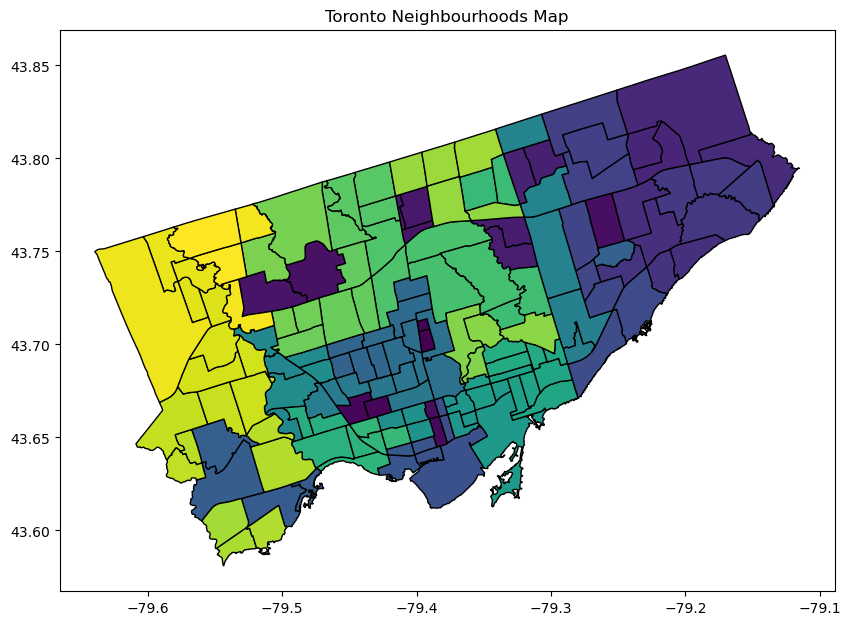

In [51]:
#| include: false

# Plot the neighbourhood boundaries
toronto_gdf.plot(figsize=(10, 8), edgecolor="black", cmap="viridis")
plt.title("Toronto Neighbourhoods Map")
plt.show()


#### Check stations_df

In [52]:
#| include: false

print(stations_df.info())

# Change 'station' column to category type
stations_df['station'] = stations_df['station'].astype('category')
print(stations_df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   station    70 non-null     object 
 1   latitude   70 non-null     float64
 2   longitude  70 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.8+ KB
None
station      category
latitude      float64
longitude     float64
dtype: object


In [53]:
#| include: false

import folium

# Example: replace this with your actual DataFrame
df = stations_df
# Center the map on the average location
map_center = [df['latitude'].mean(), df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Add station markers
for _, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['station'],
        icon=folium.Icon(color='blue', icon='train', prefix='fa')
    ).add_to(m)

# Display the map in Jupyter or export as HTML
m.save('station_map.html')
m

In [54]:
#| include: false

# Define manual corrections
corrections = {
    'QUEEN STATION': {'latitude': 43.6529083, 'longitude': -79.3794575},
    'LAWRENCE STATION': {'latitude': 43.7250043, 'longitude': -79.4022502}
}

# Apply corrections to stations_df
for station, coords in corrections.items():
    stations_df.loc[stations_df['station'] == station, ['latitude', 'longitude']] = coords['latitude'], coords['longitude']


In [55]:
#| include: false

# Example: replace this with your actual DataFrame
df = stations_df
# Center the map on the average location
map_center = [df['latitude'].mean(), df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Add station markers
for _, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['station'],
        icon=folium.Icon(color='blue', icon='train', prefix='fa')
    ).add_to(m)

# Display the map in Jupyter or export as HTML
m.save('station_map.html')
m

In [56]:
#| include: false

# Save stations_df to data folder
stations_df.to_csv(os.path.join(data_folder, "stations_data.csv"), index=False)
print("File saved successfully in the data folder!")

File saved successfully in the data folder!


#### Check weather_df

In [57]:
#| include: false
# Checking for missing values and duplicates in weather_df
print("\nMissing Values in Weather DataFrame:\n", weather_df.isnull().sum())
print("\nDuplicate Rows in Weather DataFrame:", weather_df.duplicated().sum())



Missing Values in Weather DataFrame:
 date                      0
temperature               0
relative_humidity         0
apparent_temperature      0
precipitation             0
rain                      0
snowfall                  0
snow_depth              504
cloud_cover               0
wind_speed                0
wind_gusts                0
dtype: int64

Duplicate Rows in Weather DataFrame: 0


In [58]:
#| include: false

# check the date of these na entries in snow_depth
print(weather_df[pd.isna(weather_df['snow_depth'])].head())

                          date  temperature  relative_humidity  \
4772 2024-07-18 00:00:00+00:00    22.535999          80.621361   
4773 2024-07-18 01:00:00+00:00    20.685999          72.593399   
4774 2024-07-18 02:00:00+00:00    19.886000          71.061661   
4775 2024-07-18 03:00:00+00:00    19.236000          65.814766   
4776 2024-07-18 04:00:00+00:00    18.386000          68.275818   

      apparent_temperature  precipitation  rain  snowfall  snow_depth  \
4772             25.693537            0.0   0.0       0.0         NaN   
4773             21.568476            0.0   0.0       0.0         NaN   
4774             19.342655            0.0   0.0       0.0         NaN   
4775             17.988487            0.0   0.0       0.0         NaN   
4776             17.122284            0.0   0.0       0.0         NaN   

      cloud_cover  wind_speed  wind_gusts  
4772          9.0    1.609969    8.640000  
4773          8.0    6.952754   16.559999  
4774         15.0   13.854155   

In [59]:
#| include: false

# replace NaN entries in snow_depth to 0
weather_df['snow_depth'] = weather_df['snow_depth'].fillna(0)

print("\nMissing Values in Weather DataFrame:\n", weather_df.isnull().sum())


Missing Values in Weather DataFrame:
 date                    0
temperature             0
relative_humidity       0
apparent_temperature    0
precipitation           0
rain                    0
snowfall                0
snow_depth              0
cloud_cover             0
wind_speed              0
wind_gusts              0
dtype: int64


In [60]:
#| include: false

# Ensure 'date' column is in datetime format
weather_df['date'] = pd.to_datetime(weather_df['date'])

# Extract the hour from the 'date' column and create a new 'hour' column (numeric type)
weather_df['hour'] = weather_df['date'].dt.strftime('%H').astype(int)

# Convert 'date' column to only contain the date (drop time) and change type to datetime64[ns]
weather_df['date'] = weather_df['date'].dt.date  # Convert to date only
weather_df['date'] = pd.to_datetime(weather_df['date'])  # Convert back to datetime64[ns]

# Display result
print(weather_df.dtypes)
print(weather_df.head())

date                    datetime64[ns]
temperature                    float32
relative_humidity              float32
apparent_temperature           float32
precipitation                  float32
rain                           float32
snowfall                       float32
snow_depth                     float32
cloud_cover                    float32
wind_speed                     float32
wind_gusts                     float32
hour                             int64
dtype: object
        date  temperature  relative_humidity  apparent_temperature  \
0 2024-01-01        0.036          87.680656             -4.330923   
1 2024-01-01       -0.314          86.681801             -4.882948   
2 2024-01-01       -0.814          84.406464             -5.416182   
3 2024-01-01       -1.114          82.810249             -5.712741   
4 2024-01-01       -1.614          81.205139             -6.188531   

   precipitation  rain  snowfall  snow_depth  cloud_cover  wind_speed  \
0            0.1   0.0  

In [61]:
#| include: false
# Summary statistics for Weather Data (formatted)
weather_summary = weather_df.describe().T  # Transpose for better readability
weather_summary.style.set_caption("Weather Data Summary").format("{:.2f}")

,count,mean,min,25%,50%,75%,max,std
date,8784.00,.2f,.2f,.2f,.2f,.2f,.2f,nan
temperature,8784.00,9.90,-17.36,2.19,9.89,17.99,30.49,9.46
relative_humidity,8784.00,74.29,20.97,64.03,75.59,86.42,100.00,14.95
apparent_temperature,8784.00,7.50,-22.25,-2.25,6.68,17.52,34.16,11.81
precipitation,8784.00,0.11,0.00,0.00,0.00,0.00,14.40,0.55
rain,8784.00,0.10,0.00,0.00,0.00,0.00,14.40,0.54
snowfall,8784.00,0.01,0.00,0.00,0.00,0.00,2.52,0.07
snow_depth,8784.00,0.01,0.00,0.00,0.00,0.00,0.10,0.02
cloud_cover,8784.00,61.46,0.00,12.00,87.00,100.00,100.00,42.21
wind_speed,8784.00,13.24,0.00,8.23,12.07,17.33,42.35,6.68


### Data Wrangling

In [62]:
#| include: false
print("2024 Subway Delay data", delay_df.info())
print("2021 Neighbourhood population data", pop_df.info())
print("Neighbourhood shapefile", toronto_gdf.info())
print("Station Data", stations_df.info())
print("2024 Hourly Weather data", weather_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9038 entries, 2 to 26466
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             9038 non-null   datetime64[ns]
 1   time             9038 non-null   object        
 2   day              9038 non-null   category      
 3   code             9038 non-null   category      
 4   min_delay        9038 non-null   int64         
 5   bound            9038 non-null   category      
 6   line             9038 non-null   category      
 7   cleaned_station  9038 non-null   category      
 8   hour             9038 non-null   int64         
dtypes: category(5), datetime64[ns](1), int64(2), object(1)
memory usage: 405.5+ KB
2024 Subway Delay data None
<class 'pandas.core.frame.DataFrame'>
Index: 158 entries, West Humber-Clairville to South Eglinton-Davisville
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------     

In [63]:
#| include: false

# Merge population data into the Toronto GeoDataFrame
toronto_gdf = toronto_gdf.merge(pop_df, on="neighbourhood_id", how="left")

# Display result
print(toronto_gdf.head())


   neighbourhood_id  AREA_ID2  AREA_AT3  PARENT_4 AREA_SH5 AREA_LO6  \
0                 1   2502366  26022881         0      174      174   
1                 2   2502365  26022880         0      173      173   
2                 3   2502364  26022879         0      172      172   
3                 4   2502363  26022878         0      171      171   
4                 5   2502362  26022877         0      170      170   

                    AREA_NA7                         AREA_DE8  \
0  South Eglinton-Davisville  South Eglinton-Davisville (174)   
1              North Toronto              North Toronto (173)   
2         Dovercourt Village         Dovercourt Village (172)   
3   Junction-Wallace Emerson   Junction-Wallace Emerson (171)   
4         Yonge-Bay Corridor         Yonge-Bay Corridor (170)   

                               CLASSIF9 CLASSIF10   OBJECTI11  \
0  Not an NIA or Emerging Neighbourhood        NA  17824737.0   
1  Not an NIA or Emerging Neighbourhood        NA  1

In [64]:
#| include: false

# Convert stations_df to a GeoDataFrame with geometry
stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df["longitude"], stations_df["latitude"]),
    crs="EPSG:4326"  # Ensure CRS is set correctly
)

# Convert toronto_gdf to the same CRS
toronto_gdf = toronto_gdf.to_crs(epsg=32617)  # UTM Zone 17N (for accurate distance)
stations_gdf = stations_gdf.to_crs(epsg=32617)

# Buffer stations by 0.5 km (500 meters)
stations_gdf["buffer"] = stations_gdf.geometry.buffer(500)

# Ensure the active geometry column is set **before spatial join**
stations_gdf.set_geometry("buffer", inplace=True)

# Spatial join: Find neighbourhoods within 0.5 km of each station
service_population = gpd.sjoin(toronto_gdf, stations_gdf, predicate="intersects")

# Sum the population for each station
service_population = service_population.groupby("station")["population"].sum().reset_index()

# Merge the population count back into stations_df
stations_df = stations_df.merge(service_population, on="station", how="left")

# Rename column for clarity
stations_df.rename(columns={"population": "service_population"}, inplace=True)

# Display result
print(stations_df.head())



             station   latitude  longitude  service_population
0      FINCH STATION  43.782750 -79.414888             64205.0
1  ST ANDREW STATION  43.647792 -79.384871             77825.0
2    KIPLING STATION  43.637532 -79.535604             43120.0
3  GREENWOOD STATION  43.682476 -79.330280             60260.0
4  ISLINGTON STATION  43.645335 -79.524816             79885.0


In [65]:
#| include: false

# Merge on date and hour
merged_df = delay_df.merge(weather_df, on=["date", "hour"], how="inner")

# Display result
print(merged_df.head())


        date   time     day   code  min_delay bound line  \
0 2024-01-01  07:57  Monday  TUNOA         12     N   YU   
1 2024-01-01  08:41  Monday  TUNOA          6     N   YU   
2 2024-01-01  08:42  Monday  TUNIP          6     N   YU   
3 2024-01-01  09:09  Monday  PUOPO          7     S   YU   
4 2024-01-01  09:17  Monday  PUOPO          6     S   YU   

         cleaned_station  hour  temperature  relative_humidity  \
0  SHEPPARD WEST STATION     7       -1.114          82.810249   
1       EGLINTON STATION     8       -1.614          81.205139   
2  SHEPPARD WEST STATION     8       -1.614          81.205139   
3       ST CLAIR STATION     9       -2.014          78.137016   
4     SUMMERHILL STATION     9       -2.014          78.137016   

   apparent_temperature  precipitation  rain  snowfall  snow_depth  \
0             -5.712741            0.1   0.0      0.07        0.02   
1             -6.188531            0.2   0.0      0.14        0.02   
2             -6.188531         

In [66]:
#| include: false

# Merge on station names being equal
merged_df = merged_df.merge(
    stations_df[["station", "service_population"]],  # Use "station" from stations_df
    left_on="cleaned_station",  # Use "cleaned_station" from merged_df
    right_on="station",  # Merge with "station" from stations_df
    how="left"
)

# Drop redundant "station" column from stations_df if needed
merged_df.drop(columns=["station"], inplace=True)

# Display result
print(merged_df.head())
print(merged_df.info())


        date   time     day   code  min_delay bound line  \
0 2024-01-01  07:57  Monday  TUNOA         12     N   YU   
1 2024-01-01  08:41  Monday  TUNOA          6     N   YU   
2 2024-01-01  08:42  Monday  TUNIP          6     N   YU   
3 2024-01-01  09:09  Monday  PUOPO          7     S   YU   
4 2024-01-01  09:17  Monday  PUOPO          6     S   YU   

         cleaned_station  hour  temperature  relative_humidity  \
0  SHEPPARD WEST STATION     7       -1.114          82.810249   
1       EGLINTON STATION     8       -1.614          81.205139   
2  SHEPPARD WEST STATION     8       -1.614          81.205139   
3       ST CLAIR STATION     9       -2.014          78.137016   
4     SUMMERHILL STATION     9       -2.014          78.137016   

   apparent_temperature  precipitation  rain  snowfall  snow_depth  \
0             -5.712741            0.1   0.0      0.07        0.02   
1             -6.188531            0.2   0.0      0.14        0.02   
2             -6.188531         

In [67]:
#| include: false
# Checking for missing values and duplicates in merged_df
print("\nMissing Values in Merged DataFrame:\n", merged_df.isnull().sum())
print("\nDuplicate Rows in Merged DataFrame:", merged_df.duplicated().sum())


Missing Values in Merged DataFrame:
 date                    0
time                    0
day                     0
code                    0
min_delay               0
bound                   0
line                    0
cleaned_station         0
hour                    0
temperature             0
relative_humidity       0
apparent_temperature    0
precipitation           0
rain                    0
snowfall                0
snow_depth              0
cloud_cover             0
wind_speed              0
wind_gusts              0
service_population      0
dtype: int64

Duplicate Rows in Merged DataFrame: 0


In [68]:
#| include: false

# rename cleaned_station to station
merged_df.rename(columns={"cleaned_station": "station"}, inplace=True)

In [69]:
#| include: false

# save merged_df to use in report

# Define the path to the data folder
data_folder = "../data"

# Create the folder if it doesn't exist
os.makedirs(data_folder, exist_ok=True)

# Save stations_df and weather_df as CSV
merged_df.to_csv(os.path.join(data_folder, "merged_data.csv"), index=False)

print("File saved successfully in the data folder!")

File saved successfully in the data folder!


### EDA

In [70]:
#| echo: false

# Select numeric columns
numeric_cols = merged_df.select_dtypes(include=['number']).columns

# Compute summary statistics
summary_stats = merged_df[numeric_cols].describe().T

# Rename column headers
summary_stats = summary_stats.rename(columns={
    "count": "Count", 
    "mean": "Mean", 
    "std": "Std Dev", 
    "min": "Minimum", 
    "25%": "Q1", 
    "50%": "Median", 
    "75%": "Q3", 
    "max": "Maximum"
})

# Rename row index (variable names)
summary_stats.index = summary_stats.index.str.replace("_", " ").str.title()

styled_summary = summary_stats.style.set_caption("Table 1: Summary Statistics of Merged Data") \
                                   .format("{:.2f}") \
                                   .set_table_styles([
                                       {"selector": "thead", "props": [("font-weight", "bold"), ("background-color", "#f4f4f4")]},
                                       {"selector": "tbody tr:nth-child(even)", "props": [("background-color", "#f9f9f9")]},
                                       {"selector": "td, th", "props": [("max-width", "140px"), ("white-space", "nowrap")]}
                                   ])

styled_summary

,Count,Mean,Std Dev,Minimum,Q1,Median,Q3,Maximum
Min Delay,9028.00,6.56,4.79,2.00,4.00,5.00,7.00,30.00
Hour,9028.00,12.96,6.02,0.00,8.00,13.00,18.00,23.00
Temperature,9028.00,9.66,9.46,-16.01,1.94,9.44,17.79,30.49
Relative Humidity,9028.00,73.68,15.41,21.45,62.80,75.17,86.09,100.00
Apparent Temperature,9028.00,7.17,11.79,-21.34,-2.51,6.09,17.18,33.97
Precipitation,9028.00,0.12,0.56,0.00,0.00,0.00,0.00,14.40
Rain,9028.00,0.11,0.55,0.00,0.00,0.00,0.00,14.40
Snowfall,9028.00,0.01,0.06,0.00,0.00,0.00,0.00,1.89
Snow Depth,9028.00,0.01,0.02,0.00,0.00,0.00,0.00,0.10
Cloud Cover,9028.00,62.90,41.79,0.00,15.00,90.00,100.00,100.00


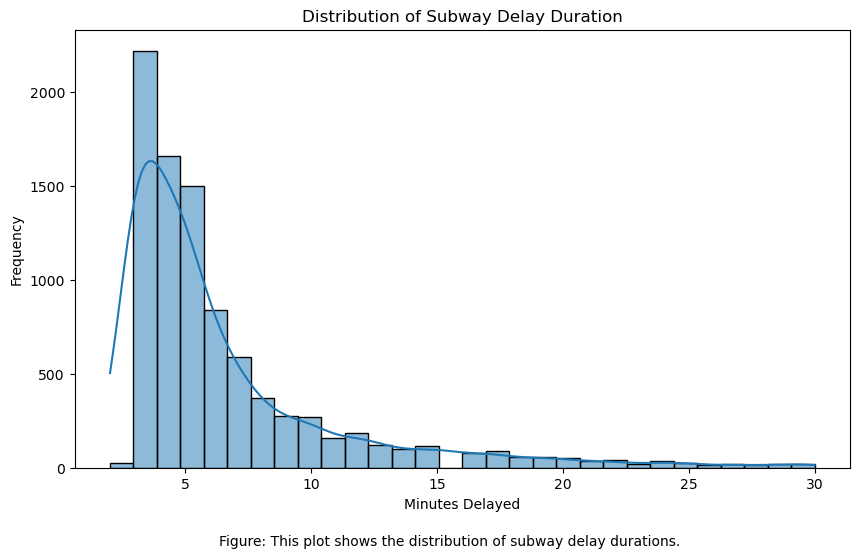

In [71]:
#| echo: false

# Distribution of Delay Duration
plt.figure(figsize=(10,6))
sns.histplot(merged_df['min_delay'], bins=30, kde=True)
plt.title("Distribution of Subway Delay Duration")
plt.xlabel("Minutes Delayed")
plt.ylabel("Frequency")

# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.15)  # Moves the entire plot up

#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure: This plot shows the distribution of subway delay durations.", 
            ha="center", fontsize=10, wrap=True)
plt.show()


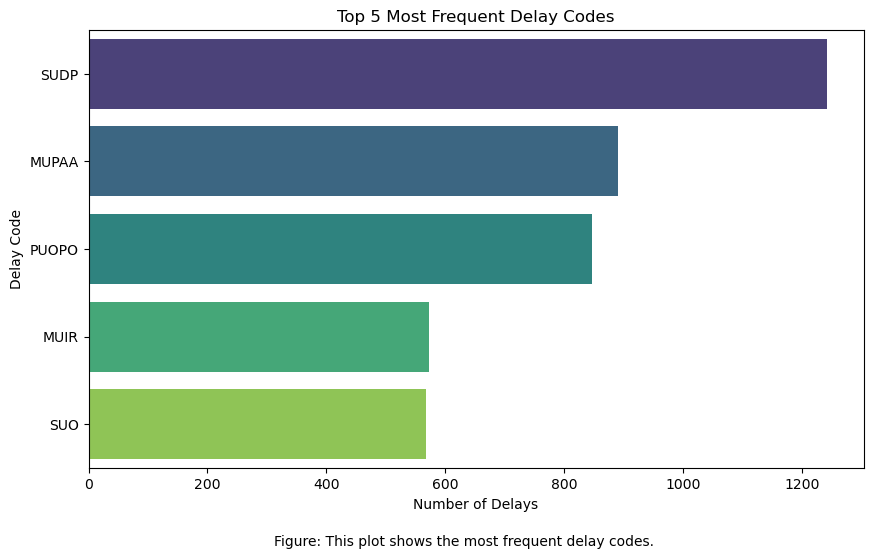

In [72]:
#| echo: false

# Get the top 5 most frequent delay codes
top_delay_codes = (
    merged_df['code']
    .value_counts()
    .nlargest(5)  # Select top 5
    .reset_index()
)
top_delay_codes.columns = ['code', 'count']

# Filter the original dataframe to only include the top 5 codes
filtered_df = merged_df[merged_df['code'].isin(top_delay_codes['code'])]

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df, y='code', order=top_delay_codes['code'], palette='viridis')

plt.title("Top 5 Most Frequent Delay Codes")
plt.xlabel("Number of Delays")
plt.ylabel("Delay Code")

# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.15)  # Moves the entire plot up

#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure: This plot shows the most frequent delay codes.", 
            ha="center", fontsize=10, wrap=True)

plt.show()

In [73]:
#| include: false
# SUDP = Disorderly Patron
# MUPAA = Passenger Assistance Alarm Activated - No Trouble Found
# SUO = Passenger Other
# PUOPO = OPTO (COMMS) Train Door Monitoring
# MUIR = Injured or ill Customer (On Train) - Medical Aid Refused

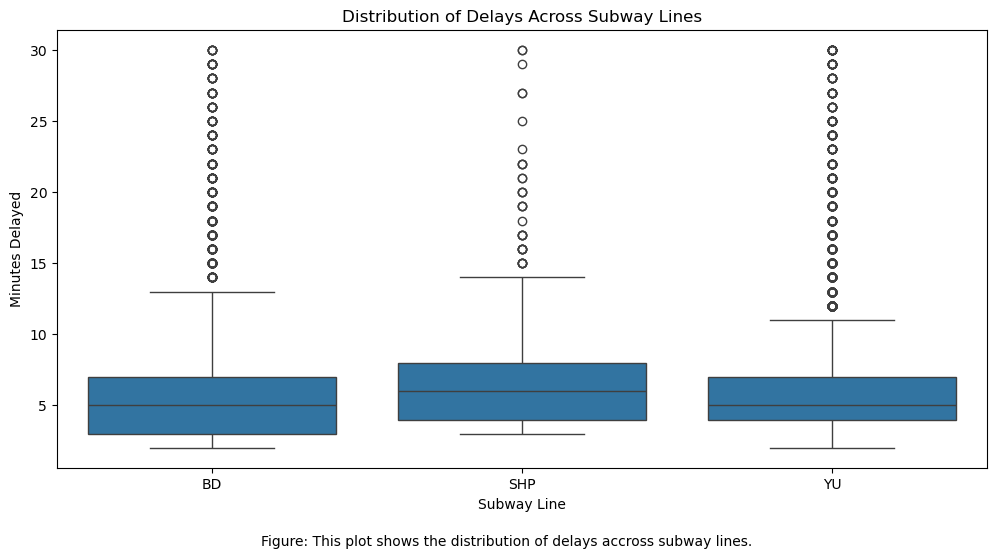

In [74]:
#| echo: false
# Delays by Line
plt.figure(figsize=(12,6))
sns.boxplot(x=merged_df['line'], y=merged_df['min_delay'])
plt.xticks()
plt.title("Distribution of Delays Across Subway Lines")
plt.xlabel("Subway Line")
plt.ylabel("Minutes Delayed")

# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.15)  # Moves the entire plot up

#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure: This plot shows the distribution of delays accross subway lines.", 
            ha="center", fontsize=10, wrap=True)

plt.show()


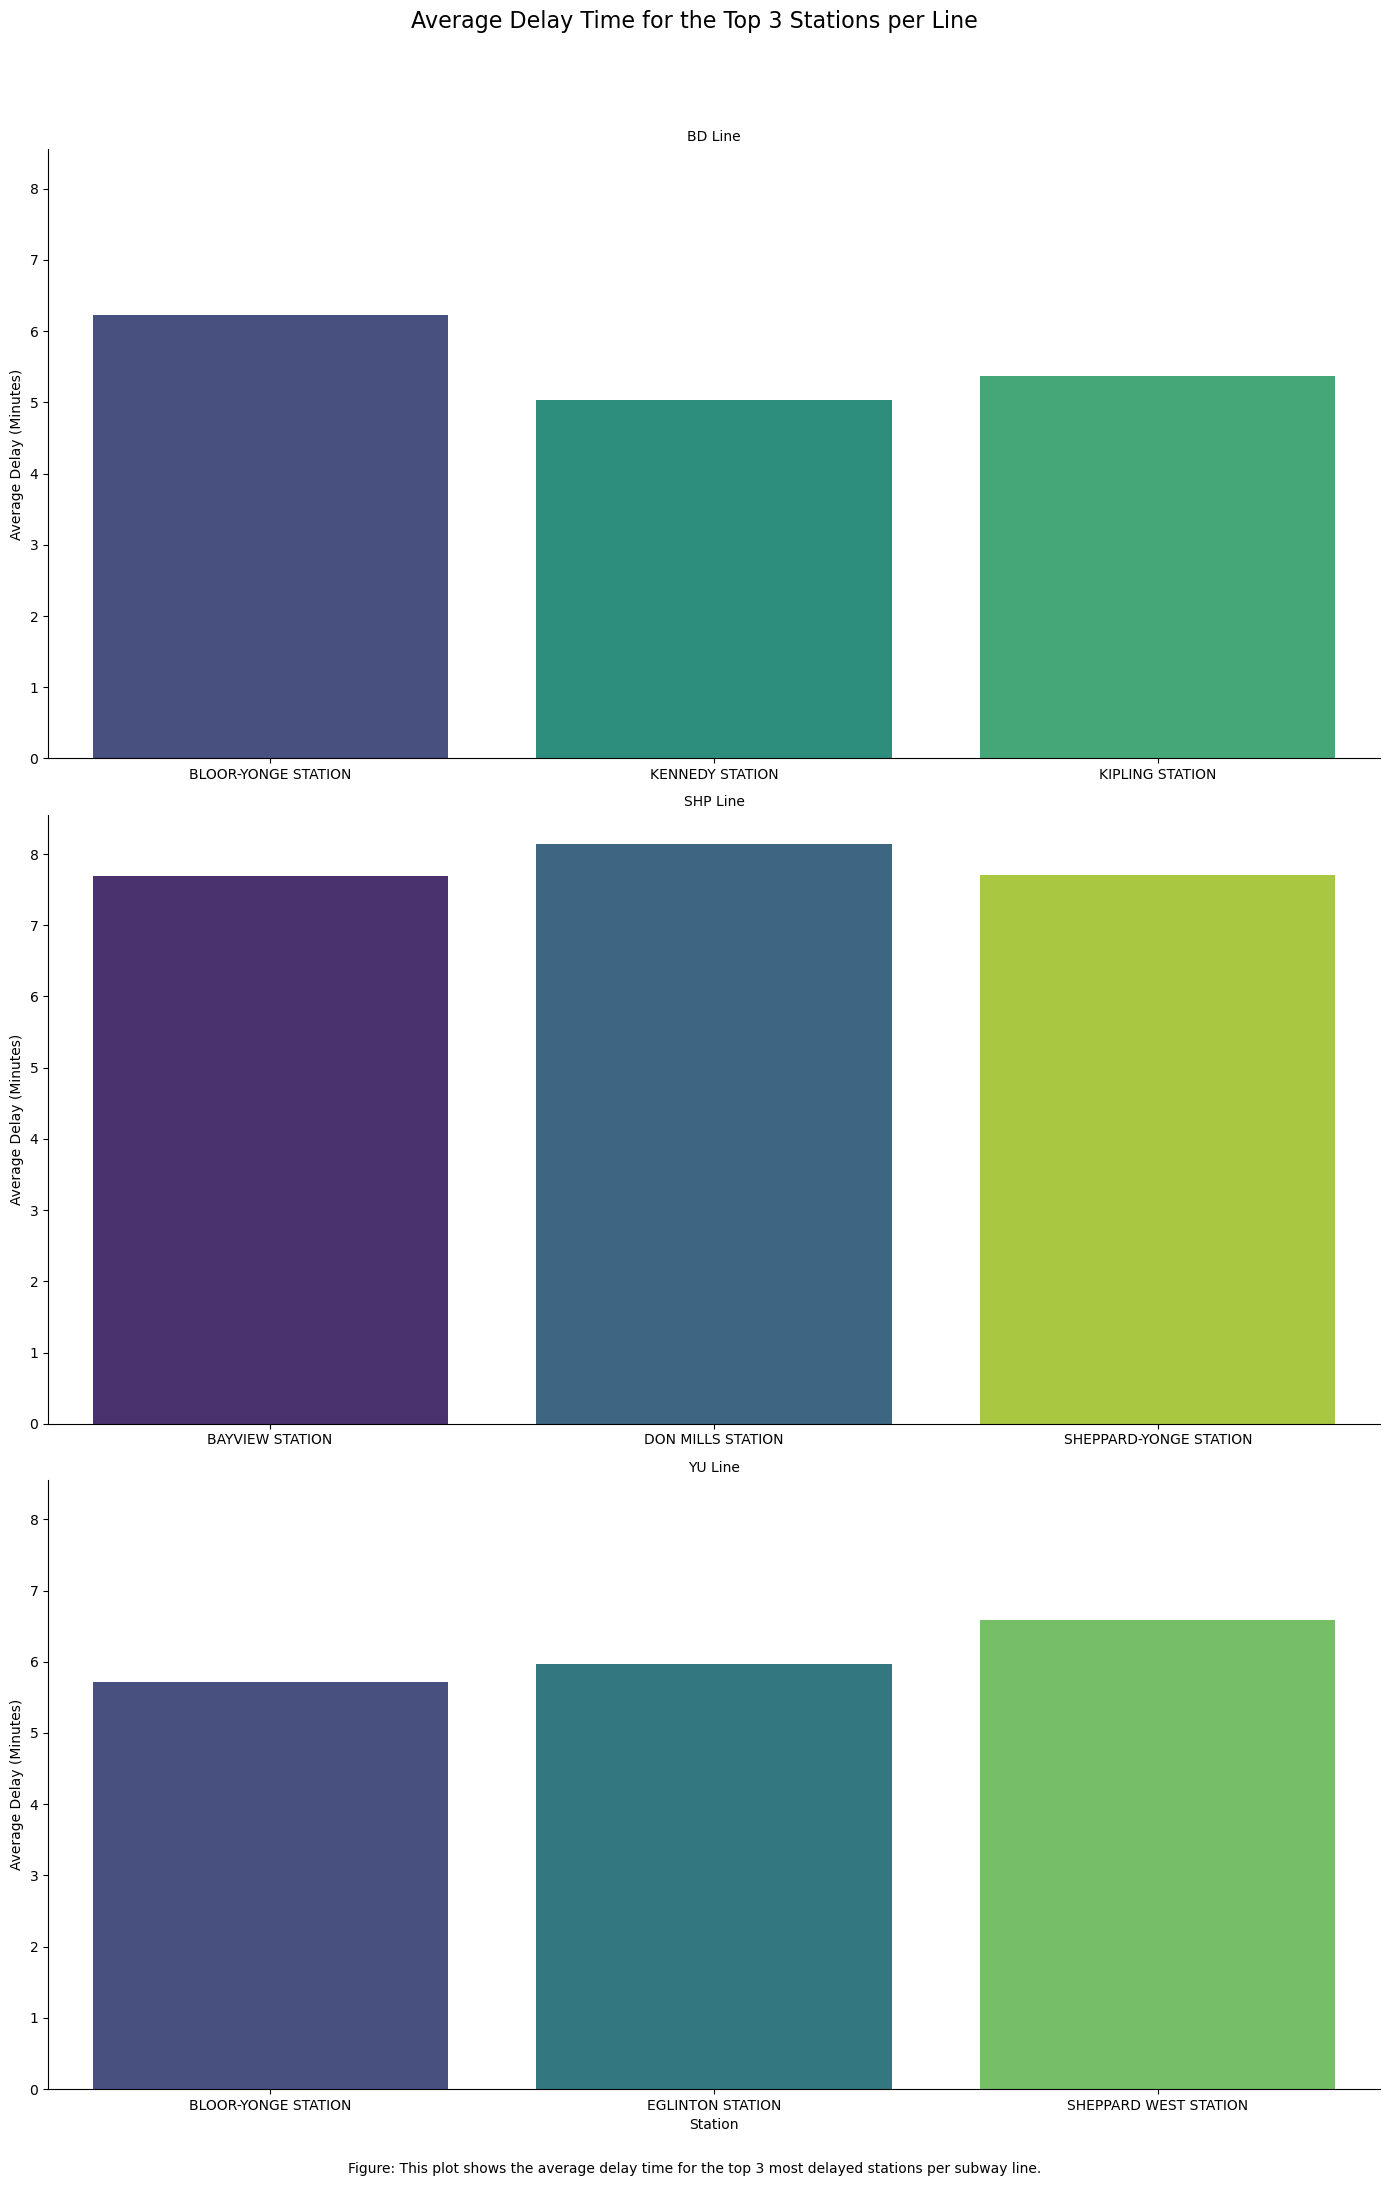

In [75]:
#| echo: false

# make 'station' str type (will reverse at the end)
merged_df["station"] = merged_df["station"].astype(str)

# Get the top 3 stations per line based on delay count (ensuring no duplicates across lines)
top_stations_per_line = (
    merged_df.groupby(['line', 'station'])
    .size()
    .reset_index(name="delay_count")
    .sort_values(['line', 'delay_count'], ascending=[True, False])  # Sort within each line
    .groupby('line')  # Group by line
    .head(3)  # Select top 3 stations per line
)

# Filter delay_df to include only the selected top stations
filtered_df = merged_df.merge(top_stations_per_line[['line', 'station']], on=['line', 'station'])

# Compute average delay for these stations per line
avg_delay_per_line = (
    filtered_df.groupby(['line', 'station'])['min_delay']
    .mean()
    .reset_index()
)

# Create Faceted Plot by Line with stations on X-axis and shared Y-axis
g = sns.catplot(
    data=avg_delay_per_line,
    x="station",  # Stations on X-axis
    y="min_delay",  # Average delay time on Y-axis
    col="line",  # Facet by subway line
    kind="bar",
    col_wrap=1,  # Adjust layout
    height=7,  # Make plot taller
    aspect=2,  # Widen subplots
    palette="viridis",
    sharey=True,  # Use shared Y-axis for uniformity
    sharex=False,  # Ensure correct spacing of station names
    legend=False  # Remove legend
)

g.set_axis_labels("Station", "Average Delay (Minutes)")
g.set_titles("{col_name} Line")
g.fig.suptitle("Average Delay Time for the Top 3 Stations per Line", y=1.05, fontsize=16)
    
# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.06)  # Moves the entire plot up
    
#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure: This plot shows the average delay time for the top 3 most delayed stations per subway line.", 
            ha="center", fontsize=10, wrap=True)

plt.show()

# return 'cleaned_station' to categorical type
merged_df["station"] = merged_df["station"].astype('category')

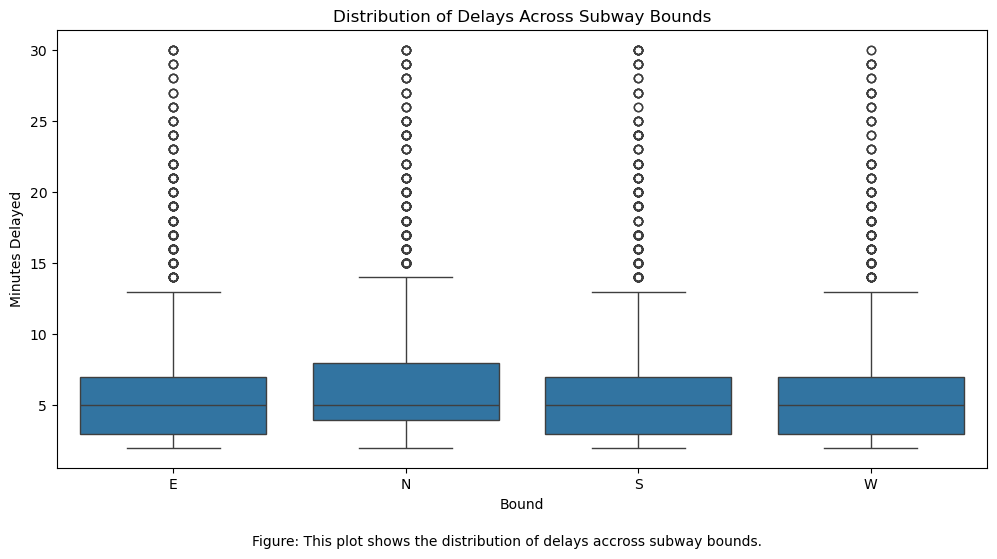

In [76]:
#| echo: false

# Delays by Bound
plt.figure(figsize=(12,6))
sns.boxplot(x=merged_df['bound'], y=merged_df['min_delay'])
plt.xticks()
plt.title("Distribution of Delays Across Subway Bounds")
plt.xlabel("Bound")
plt.ylabel("Minutes Delayed")

# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.15)  # Moves the entire plot up

#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure: This plot shows the distribution of delays accross subway bounds.", 
            ha="center", fontsize=10, wrap=True)

plt.show()

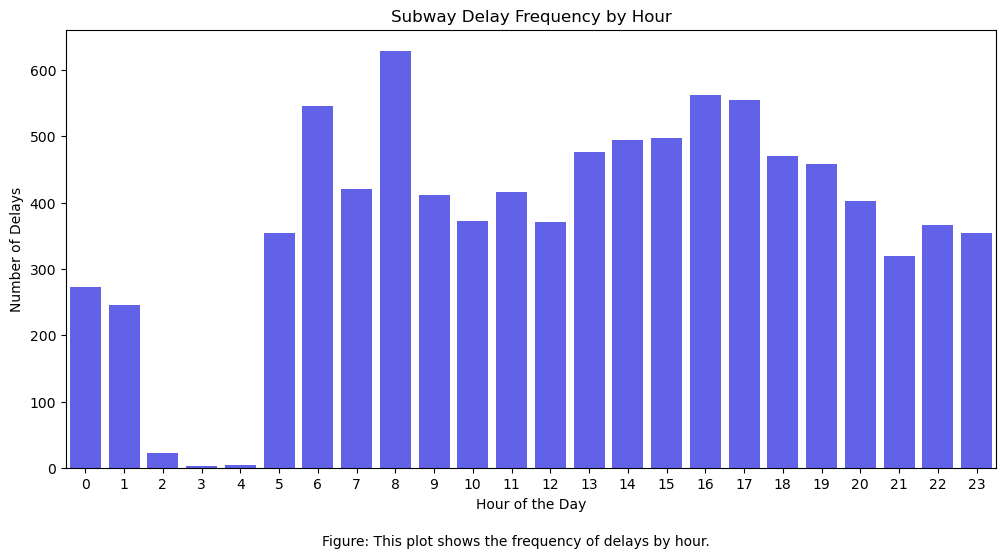

In [77]:
#| include: false

# Aggregate delay count and average delay per hour
delay_by_hour = merged_df.groupby('hour').agg(
    delay_count=('min_delay', 'count'),
    avg_delay=('min_delay', 'mean')
).reset_index()

# Frequency of Delays per Hour
plt.figure(figsize=(12, 6))
sns.barplot(x=delay_by_hour['hour'], y=delay_by_hour['delay_count'], color='blue', alpha=0.7)
plt.title("Subway Delay Frequency by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Delays")
plt.xticks(range(0, 24))  # Ensure x-axis covers all hours (0-23)

# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.15)  # Moves the entire plot up

#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure: This plot shows the frequency of delays by hour.", 
            ha="center", fontsize=10, wrap=True)

plt.show()

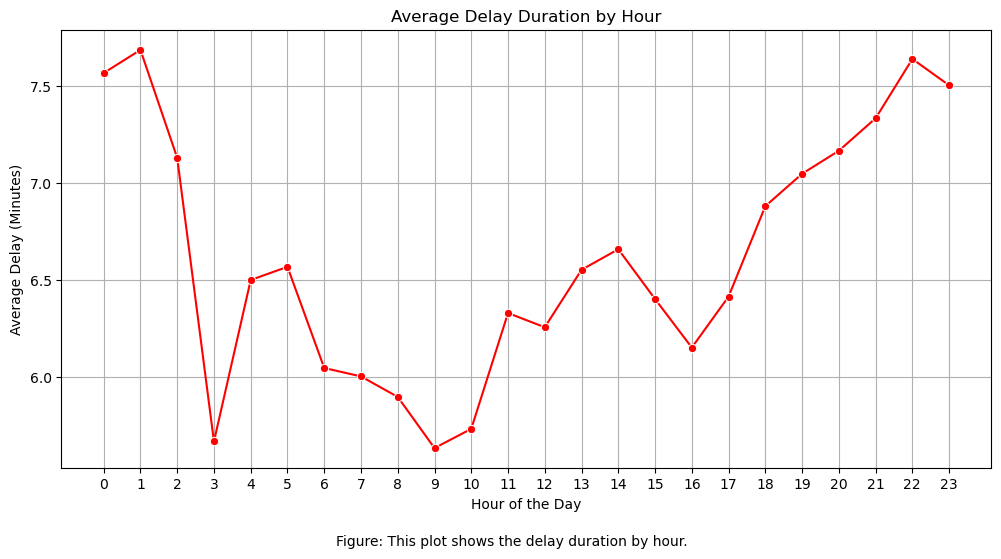

In [78]:
#| echo: false

# Average Delay Duration per Hour
plt.figure(figsize=(12, 6))
sns.lineplot(x=delay_by_hour['hour'], y=delay_by_hour['avg_delay'], marker='o', color='red')
plt.title("Average Delay Duration by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Delay (Minutes)")
plt.xticks(range(0, 24))  # Ensure x-axis covers all hours (0-23)
plt.grid(True)  # Add grid for readability

# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.15)  # Moves the entire plot up

#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure: This plot shows the delay duration by hour.", 
            ha="center", fontsize=10, wrap=True)

plt.show()

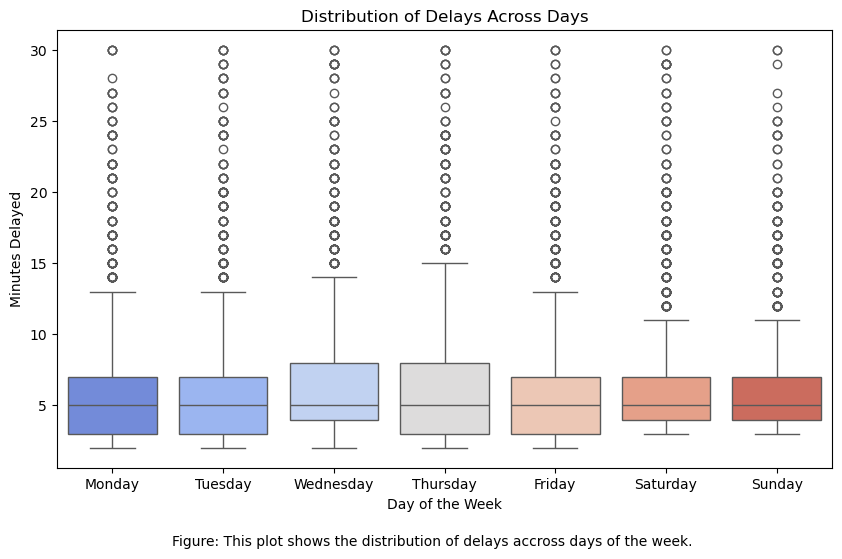

In [79]:
#| echo: false

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_df['day'], y=merged_df['min_delay'], order=day_order, palette="coolwarm")
plt.xticks()
plt.title("Distribution of Delays Across Days")
plt.xlabel("Day of the Week")
plt.ylabel("Minutes Delayed")

# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.15)  # Moves the entire plot up

#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure: This plot shows the distribution of delays accross days of the week.", 
            ha="center", fontsize=10, wrap=True)

plt.show()

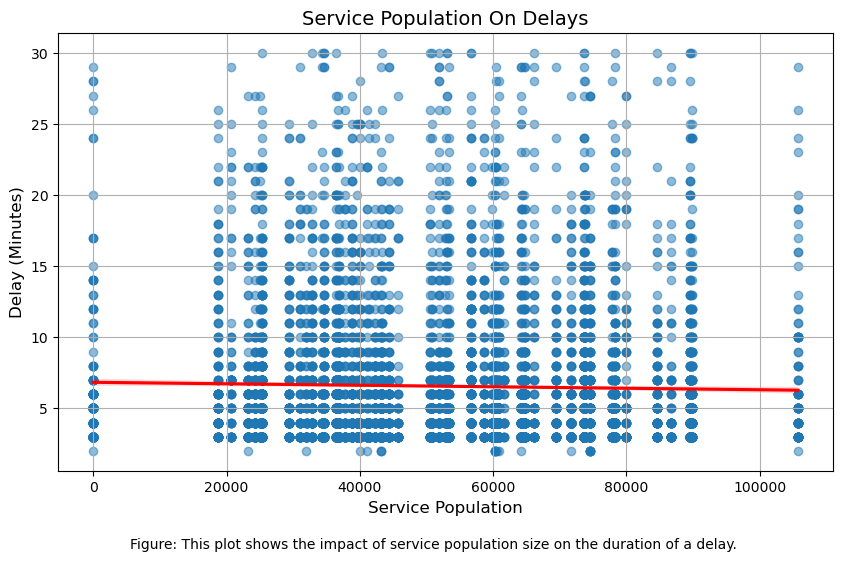

In [80]:
#| echo: false
plt.figure(figsize=(10, 6))
sns.regplot(x="service_population", y="min_delay", data=merged_df, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.title("Service Population On Delays", fontsize=14)
plt.xlabel("Service Population", fontsize=12)
plt.ylabel("Delay (Minutes)", fontsize=12)
plt.grid(True)

# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.15)  # Moves the entire plot up

#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure: This plot shows the impact of service population size on the duration of a delay.", 
            ha="center", fontsize=10, wrap=True)

plt.show()


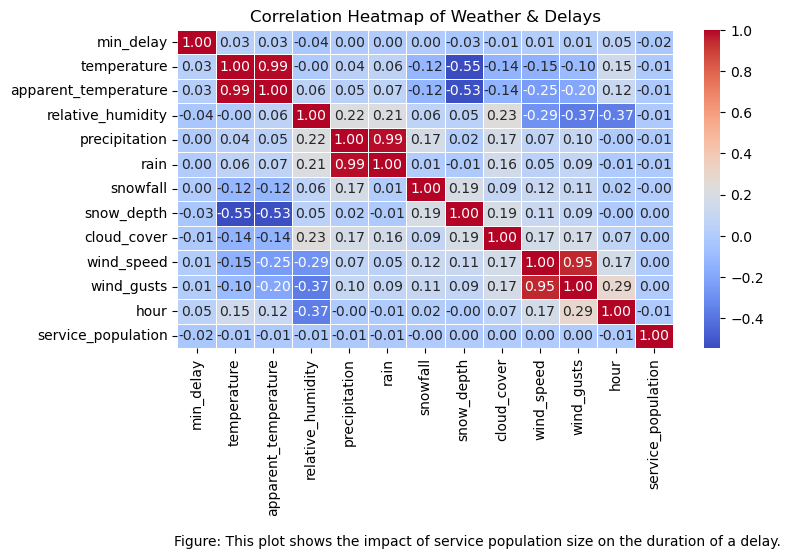

In [81]:
#| echo: false

# Compute correlation matrix 2
corr2_matrix = merged_df[["min_delay", "temperature", "apparent_temperature", "relative_humidity", 
                          "precipitation", "rain", "snowfall", "snow_depth", "cloud_cover", "wind_speed", 
                          "wind_gusts", "hour", "service_population"]].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr2_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Weather & Delays")

# Adjust spacing so caption is at the bottom
plt.subplots_adjust(bottom=0.35)  # Moves the entire plot up

#  Add caption below the plot
plt.figtext(0.5, 0.02, "Figure: This plot shows the impact of service population size on the duration of a delay.", 
            ha="center", fontsize=10, wrap=True)


plt.show()


In [82]:
#| echo: false

# Fit the ANOVA model
anova_model = smf.ols("min_delay ~ C(day) + C(bound) + C(line) + C(station)", data=merged_df).fit()

# Perform ANOVA test
anova_table = sm.stats.anova_lm(anova_model)

# Rename column headers
anova_table = anova_table.rename(columns={
    "df": "Degrees of Freedom", 
    "sum_sq": "Sum of Squares", 
    "mean_sq": "Mean Square", 
    "F": "F-Statistic", 
    "PR(>F)": "p-Value"
})

# Rename index names (variable names)
anova_table.index = anova_table.index.str.replace("C(", "").str.replace(")", "").str.replace("_", " ").str.title()

# Apply professional styling (matching summary table)
styled_anova = anova_table.style.set_caption("Table 2: ANOVA Results on the Impact of Subway Line on Delay Time") \
                               .format("{:.4f}") \
                               .set_table_styles([
                                   {"selector": "thead", "props": [("font-weight", "bold"), ("background-color", "#f4f4f4")]},
                                   {"selector": "tbody tr:nth-child(even)", "props": [("background-color", "#f9f9f9")]}
                               ]) \
                               .set_properties(**{"border": "1px solid black", "text-align": "center", "padding": "5px"})

# Display styled table
styled_anova


,Degrees of Freedom,Sum of Squares,Mean Square,F-Statistic,p-Value
Day,6.0000,170.9064,28.4844,1.2722,0.2663
Bound,3.0000,364.6444,121.5481,5.4288,0.0010
Line,2.0000,269.9193,134.9596,6.0278,0.0024
Station,69.0000,5561.1966,80.5971,3.5998,0.0000
Residual,8947.0000,200319.2190,22.3895,nan,nan
